In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import re
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv('/content/drive/MyDrive/sentiment_tweets3.csv')
df.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [4]:
df = df.rename(columns=({'message to examine':'tweet'}))
df = df.rename(columns=({'label (depression result)':'lab'}))
df.columns

Index(['Index', 'tweet', 'lab'], dtype='object')

In [5]:
df.shape
df['lab'].value_counts()

0    8000
1    2314
Name: lab, dtype: int64

looks like data is imbalanced and sorted 

###Text Preprocessing

In [6]:
def cleanhtml(phrase):
    text=re.compile('<.*?>')
    phrase=re.sub(text,' ',phrase)
    return phrase

def decont(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"PRON", " ", phrase)
    phrase = re.sub(r"pron", " ", phrase)
    #remove any url
    phrase = re.sub(r"http[s]?://\S+"," ", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    #special char
    phrase = re.sub(r'[^A-Za-z0-9]+', " ", phrase)

    phrase = re.sub(r"@+"," ", phrase)

    #remove any thing with html tags
    phrase = cleanhtml(phrase)
    return phrase


In [7]:
import nltk
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string 
nltk.download('stopwords')
nltk.download('punkt')
import spacy
nlp = spacy.load('en')
lmtzr = WordNetLemmatizer()
import re
sno= nltk.stem.SnowballStemmer('english')
def text_preprocess(text):
    lm = []
    text = nlp(text)
    for token in text:
        k=(token.lemma_)
        k=decont(k)
        #k=sno.stem(k)
        lm.append(k)
    text = " ".join(lm)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    #print(text)
    return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
df['ptt'] = df['tweet'].apply(text_preprocess)

In [9]:
df.head()

,Index,tweet,lab,ptt
0,106,just had a real good moment. i missssssssss hi...,0,real good moment missssssssss much
1,217,is reading manga http://plurk.com/p/mzp1e,0,read manga
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0,comeagainjen
3,288,@lapcat Need to send 'em to my accountant tomo...,0,lapcat need send accountant tomorrow oddly eve...
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,add MYSPACE myspace com lookthunder


In [10]:
df.to_csv("tweetp",index=False)

###Convert word to vec

In [11]:
from gensim.models import word2vec
from gensim.models import keyedvectors
import gensim
#keyedvectors.load_word2vec_format

In [12]:
i=0
list_of_sentance=[]
for sentance in df['ptt']:
    list_of_sentance.append(sentance.split())

In [13]:
list_of_sentance[2]

['comeagainjen']

In [14]:

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=gensim.models.Word2Vec(list_of_sentance,min_count=2,size=50, workers=4)
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [15]:
print(w2v_model.wv.most_similar('depression'))

[('Depression', 0.9998852610588074), ('find', 0.9998787045478821), ('show', 0.9998767375946045), ('study', 0.9998742341995239), ('try', 0.9998691082000732), ('stress', 0.9998630881309509), ('God', 0.999861478805542), ('help', 0.9998527765274048), ('check', 0.9998521208763123), ('please', 0.9998427033424377)]


In [16]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 2 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 2 times  5912
sample words  ['real', 'good', 'moment', 'much', 'read', 'comeagainjen', 'need', 'send', 'tomorrow', 'even', 'refer', 'support', 'evidence', 'though', 'add', 'myspace', 'com', 'sleepy', 'time', 'tonight', 'someone', 'already', 'say', 'home', 'mean', 'least', 'regular', '23', '24', 'c', 'possible', 'today', 'Nice', 'nite', 'twitterville', 'workout', 'Night', 'Sweet', 'dream', 'morning', 'everybody', 'finally', 'create', 'Blog', 'blog', 'Seattle', 'cnt', 'get', 'u', 'til']


In [17]:
w2v_model['depression']

array([-0.39729762,  0.36226392, -1.0026466 ,  0.15331908,  1.2739689 ,
       -0.2966897 ,  1.0287424 ,  1.3031057 , -1.1312952 ,  0.1230596 ,
        1.6900798 , -0.5722018 ,  0.97229534, -0.49459544, -0.5066823 ,
        0.25991082,  0.06737651, -0.7160111 , -0.03238073,  0.73302764,
        0.00745877,  0.25209576,  2.6642532 ,  1.1720394 , -0.11785527,
       -0.20906904,  0.7635387 , -0.19737506, -0.83542067, -0.69986016,
       -0.8456681 , -0.10368997,  0.69679743,  1.2307132 ,  0.5672457 ,
        0.23684026,  0.36044684, -0.48219806, -0.86598116, -0.9226244 ,
        0.4402309 ,  1.953751  , -0.24663617,  2.6244729 , -0.12842758,
        0.29903036, -0.03510923,  1.2711214 , -0.63145274, -0.781066  ],
      dtype=float32)

In [18]:
from tqdm import tqdm
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(list_of_sentance): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        if word in w2v_words:
            vector += w2v_model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████| 10314/10314 [00:05<00:00, 1729.60it/s]

10314
50


In [19]:
len(avg_w2v_vectors),df['lab'].shape

(10314, (10314,))

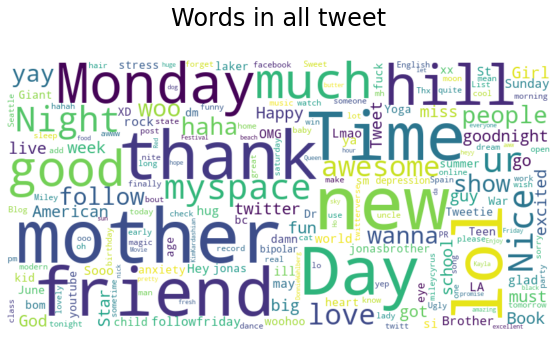

In [20]:
from wordcloud import WordCloud
words = ' '.join([text for text in w2v_words])
wordcloud = WordCloud(
    width=800, height=400, background_color='white', max_font_size=110)\
    .generate(words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words in all tweet\n', fontsize=24)
plt.axis('off')
plt.show()

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(avg_w2v_vectors, df['lab'], test_size=0.3)
#X_train, X_cv, y_train,y_cv = train_test_split(X_Train, y_Train, test_size=0.25)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [23]:
lr = LogisticRegression()
clf= SGDClassifier()

In [24]:
param={"alpha":np.logspace(-10,10,11), "penalty":["l1","l2"], "loss":["hinge","log"]}
logreg_cv=GridSearchCV(clf,param,cv=5)
logreg_cv.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'alpha': 1e-06, 'loss': 'hinge', 'penalty': 'l1'}


In [25]:
param={"C":np.logspace(-10,10,11), "penalty":["l1","l2"]}
logreg_cv=GridSearchCV(lr,param,cv=5)
logreg_cv.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 100000000.0, 'penalty': 'l2'}


In [33]:
lr=LogisticRegression(C=10000000000,penalty='l2',solver='liblinear')
clf= SGDClassifier(alpha=1e-06,loss='hinge',penalty='l1')

In [34]:
lr.fit(X_train, y_train)
clf.fit(X_train, y_train)

SGDClassifier(alpha=1e-06, penalty='l1')

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score

def conf_matrix_acc(y_true, y_pred):
    print(f'Confusion matrix\n:{confusion_matrix(y_true, y_pred)}\n')
    print(f'Accuracy score is : {accuracy_score(y_true, y_pred)}')

In [36]:
y_pred_lr = lr.predict(X_test)
y_pred_sgd = clf.predict(X_test)

In [37]:
conf_matrix_acc(y_test,y_pred_lr )
print("="*100)
print("="*100)
conf_matrix_acc(y_test,y_pred_sgd )

Confusion matrix
:[[2310   61]
 [ 139  585]]

Accuracy score is : 0.9353796445880452
Confusion matrix
:[[2241  130]
 [ 102  622]]

Accuracy score is : 0.9250403877221325


##word 2 vec complete now converting it


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
vec=model.fit(df['ptt'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [32]:

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 10314/10314 [00:49<00:00, 209.61it/s]
